<a href="https://colab.research.google.com/github/gaurav13020/Simple_Brownian_Simulator/blob/main/Simple_Brownian_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# function for simulating weiner/brownian process
def Brownian(N,days):
    """
    N is the number of time steps in a day
    days is the total # of days
    """
    b = np.random.normal(0.,1.,days*N)*np.sqrt(1/N)
    # brownian increments , variance is considered to be 1/N CHECK?
    W = np.cumsum(b)
    W=np.insert(W,0,0.)
    # brownian path
    return W, b

 # geometric brownian motion function
def GBM(So, mu, sigma, W, N,days):
    """
    So :is the start price
    mu :is mean of price
    sigma: is the volatility
    N :is the number of time steps in a day days: is the total # of days
    """
    S = []
    S.append(So)
    t= np.linspace(0.,1.,N+1)
    for i in range(1,int(days*N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        #CHECK if the formula of the process is correct
        diffusion = sigma * np.sqrt(t[i])*np.random.normal(0,1)
        S_temp = So*np.exp(drift + diffusion)
        S.append(S_temp)
    return S

def generate_gbm_prices(start_price,instance,N,days,mu,sigma):
    """
    start_price: is the initial price same as So as above instance: are number of simulations you want increments: are increments in a day, same as N above days: # of total no of trading days
    """
    ins=instance
    prices=pd.DataFrame()
    for i in range(1,ins+1):
        W=Brownian(N,days)[0] #here what to put BM or increments
        So=start_price
        temp=GBM(So,mu,sigma,W,N,days)
        prices=pd.concat([prices,pd.Series(temp)],axis=1)
    prices.columns=np.arange(1,ins+1,1)
    return prices

 #the below function labels the data properly
def give_labels(N,days,data):
    obs_nu = np.arange(0,N+1)
    final_prices=pd.DataFrame()
    for i in range(1,days+1):
        temp_ = data.loc[N*(i-1):N*i]
        day_label=[]
        for j in range(N+1):
            day_label.append('day'+str(i))
        tuples=list(zip(day_label,obs_nu))
        index=pd.MultiIndex.from_tuples(tuples,names=['DAY','#INCREMENT'])
        temp_1=pd.DataFrame(temp_.values,index=index)
        final_prices=pd.concat([final_prices,temp_1])
    return final_prices

def ochl_data(instances,N,days,data):
    data_fin=pd.DataFrame()
    zz=data
    for i in range(instances):
        for j in range(1,days+1):
            temp=pd.DataFrame({'OPEN':zz.loc['day'+str(j)][i][0],
                                            "CLOSE":zz.loc['day'+str(j)][i][N],
                                         'HIGH':max(zz.loc['day'+str(j)][i]),
                                        'LOW': min(zz.loc['day'+str(j)][i])},
                                 index=pd.MultiIndex.from_tuples([('Simulation'+str(i+1),
                                     'day'+str(j))],names=['Simulation#','DAY']))
            data_fin=pd.concat([data_fin,temp])
    return data_fin

In [2]:
import cvxopt
from cvxopt import solvers
from cvxopt import matrix
import numpy as np
from scipy.linalg import null_space
import math
from sympy import Matrix
import sympy
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
start_price=50
ins=400
N=20
days=1
mu=0
sigma=0.2
soln=generate_gbm_prices(start_price=start_price,instance=ins,N=N,days=days,mu=mu,sigma=sigma)#sample size is taken to be small #for illustration

In [4]:
soln

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
1,52.465698,50.428747,48.774961,49.863952,49.212891,48.952676,50.074414,50.687844,46.888495,46.177931,...,44.535570,44.107206,47.082521,50.010475,50.199636,49.982870,48.284034,46.357048,53.722213,53.414250
2,52.362313,51.761502,52.342147,51.989659,46.874806,43.040584,53.188229,52.721665,48.456809,44.596802,...,53.531120,51.360205,51.323946,47.914095,50.534568,47.871552,52.070235,50.800492,50.846839,50.618758
3,49.537809,49.761145,48.883495,45.478485,47.144440,51.806055,56.275209,54.490960,49.289750,46.820367,...,43.799269,57.060729,41.571517,48.392253,50.322355,53.180839,51.683787,46.540137,45.002560,48.532764
4,52.477965,57.012497,53.180072,49.477750,53.367527,45.711879,45.764315,41.527903,48.254514,52.934602,...,45.421621,49.254766,47.322922,52.968132,50.210628,53.222815,59.224526,50.508125,48.708121,57.779099
5,53.215818,52.749489,57.270376,47.588115,47.886826,44.944652,36.926333,45.713241,56.181496,47.763876,...,51.226480,53.351676,56.250314,49.949018,56.199318,44.472140,46.923370,49.094429,40.091813,46.905676
6,43.017276,45.599776,59.793286,47.099842,52.040405,49.374878,45.138389,51.060195,58.302560,47.528469,...,54.009587,54.053169,45.764103,41.396180,51.700682,54.078077,50.935289,49.872782,55.433123,50.933326
7,57.086708,61.433102,45.366934,53.945361,48.789312,36.961164,38.236626,44.108016,63.217530,48.290281,...,50.238052,60.913841,48.509733,50.478195,60.205185,50.083945,38.828421,58.088418,52.180378,50.986683
8,54.299029,40.466869,55.279198,51.053378,67.461211,48.498683,52.524763,45.308610,53.809447,48.264736,...,55.860287,49.641249,54.492160,39.861376,51.451582,56.435365,45.560436,56.748501,54.217724,47.961039
9,49.048522,63.428433,56.574657,47.183437,47.859466,50.805641,64.696961,46.075432,57.168968,54.136852,...,57.770923,47.527503,44.057628,55.426525,52.850257,44.894212,51.430150,37.724914,56.053453,53.208359


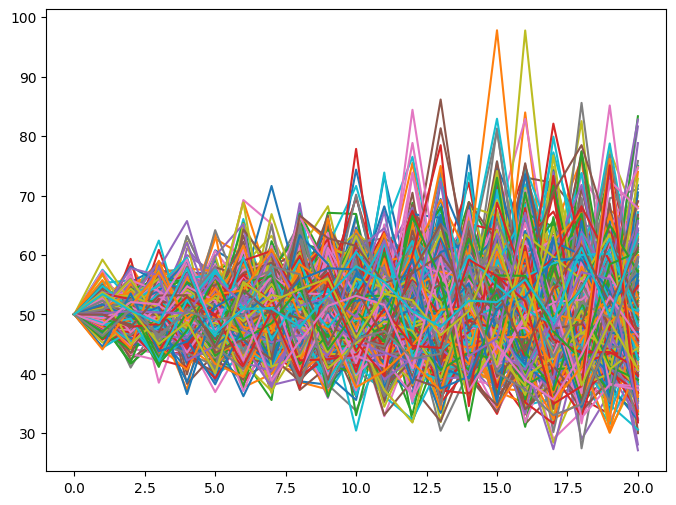

In [5]:
plt.figure(figsize=(8,6))
plt.plot(soln)
plt.show()

In [6]:
ac_w_lab= give_labels(N,days,soln)
ac_w_lab

0          1          2          3          4    \
DAY  #INCREMENT                                                          
day1 0           50.000000  50.000000  50.000000  50.000000  50.000000   
     1           52.465698  50.428747  48.774961  49.863952  49.212891   
     2           52.362313  51.761502  52.342147  51.989659  46.874806   
     3           49.537809  49.761145  48.883495  45.478485  47.144440   
     4           52.477965  57.012497  53.180072  49.477750  53.367527   
     5           53.215818  52.749489  57.270376  47.588115  47.886826   
     6           43.017276  45.599776  59.793286  47.099842  52.040405   
     7           57.086708  61.433102  45.366934  53.945361  48.789312   
     8           54.299029  40.466869  55.279198  51.053378  67.461211   
     9           49.048522  63.428433  56.574657  47.183437  47.859466   
     10          47.113152  39.357011  47.379912  46.151750  57.611802   
     11          46.819796  53.518103  46.349635  46.154699  46.846608   
     12          57.472784  52.666631  45.661857  53.893922  45.192135   
     13          59.528662  49.937128  48.009719  52.342489  49.503485   
     14          60.820043  54.381569  46.923227  44.089634  40.983406   
     15          40.631889  58.153690  66.785337  55.435055  38.457488   
     16          50.168950  46.215907  55.387630  68.800964  44.565300   
     17          59.749432  46.425764  61.727767  44.138624  32.873870   
     18          42.686416  51.783016  44.933387  40.462027  48.753978   
     19          43.688997  61.543023  56.896261  58.455278  41.178045   
     20          46.022411  48.157446  44.087844  60.011084  51.840097   

                       5          6          7          8          9    ...  \
DAY  #INCREMENT                                                         ...   
day1 0           50.000000  50.000000  50.000000  50.000000  50.000000  ...   
     1           48.952676  50.074414  50.687844  46.888495  46.177931  ...   
     2           43.040584  53.188229  52.721665  48.456809  44.596802  ...   
     3           51.806055  56.275209  54.490960  49.289750  46.820367  ...   
     4           45.711879  45.764315  41.527903  48.254514  52.934602  ...   
     5           44.944652  36.926333  45.713241  56.181496  47.763876  ...   
     6           49.374878  45.138389  51.060195  58.302560  47.528469  ...   
     7           36.961164  38.236626  44.108016  63.217530  48.290281  ...   
     8           48.498683  52.524763  45.308610  53.809447  48.264736  ...   
     9           50.805641  64.696961  46.075432  57.168968  54.136852  ...   
     10          50.919095  57.363231  66.283467  40.147023  48.532279  ...   
     11          46.792596  61.298595  49.084214  56.141004  45.450698  ...   
     12          53.953148  41.546097  48.803235  52.873133  58.226706  ...   
     13          49.994626  53.994906  57.929525  31.873889  55.945913  ...   
     14          44.219995  37.826045  44.255802  53.712205  40.104159  ...   
     15          61.169617  50.637659  56.892165  44.114579  75.706364  ...   
     16          31.523323  45.062272  40.492997  55.638223  39.139286  ...   
     17          36.912145  29.033484  62.464272  73.086207  53.661686  ...   
     18          46.728255  33.613224  54.061950  57.829906  43.720725  ...   
     19          47.411598  51.137204  64.271030  41.762698  54.877594  ...   
     20          40.677449  40.761566  47.649734  44.517346  50.174240  ...   

                       390        391        392        393        394  \
DAY  #INCREMENT                                                          
day1 0           50.000000  50.000000  50.000000  50.000000  50.000000   
     1           44.535570  44.107206  47.082521  50.010475  50.199636   
     2           53.531120  51.360205  51.323946  47.914095  50.534568   
     3           43.799269  57.060729  41.571517  48.392253  50.322355   
     4           45.421621  49.254766  47.322922  52.96813

In [7]:
final=ochl_data(ins,N,days,ac_w_lab)

In [8]:
final

,,OPEN,CLOSE,HIGH,LOW
Simulation#,DAY,,,,
Simulation1,day1,50.0,46.022411,60.820043,40.631889
Simulation2,day1,50.0,48.157446,63.428433,39.357011
Simulation3,day1,50.0,44.087844,66.785337,44.087844
Simulation4,day1,50.0,60.011084,68.800964,40.462027
Simulation5,day1,50.0,51.840097,67.461211,32.873870
...,...,...,...,...,...
Simulation396,day1,50.0,61.215160,65.183862,43.860359
Simulation397,day1,50.0,46.286776,59.619854,35.660480
Simulation398,day1,50.0,59.448601,59.448601,33.033304


In [9]:
final['ln O']= np.log(final["OPEN"])
final['ln C']= np.log(final["CLOSE"])
final['ln H']= np.log(final["HIGH"])
final['ln L']= np.log(final["LOW"])
final['u^2']=(np.log(final["HIGH"])-np.log(final["OPEN"]))**2
final['d^2']=(np.log(final["LOW"])-np.log(final["OPEN"]))**2
final['c^2']=(np.log(final["CLOSE"])-np.log(final["OPEN"]))**2
final['ud']= np.sqrt(final['u^2'])*np.sqrt(final['d^2'])
final['uc']= np.sqrt(final['u^2'])*np.sqrt(final['c^2'])
final['dc']= np.sqrt(final['d^2'])*np.sqrt(final['c^2'])


In [10]:
final

,,OPEN,CLOSE,HIGH,LOW,ln O,ln C,ln H,ln L,u^2,d^2,c^2,ud,uc,dc
Simulation#,DAY,,,,,,,,,,,,,,
Simulation1,day1,50.0,46.022411,60.820043,40.631889,3.912023,3.829128,4.107919,3.704553,0.038375,0.043044,0.006872,0.040643,0.016239,0.017198
Simulation2,day1,50.0,48.157446,63.428433,39.357011,3.912023,3.874476,4.149912,3.672674,0.056591,0.057288,0.001410,0.056939,0.008932,0.008987
Simulation3,day1,50.0,44.087844,66.785337,44.087844,3.912023,3.786184,4.201484,3.786184,0.083787,0.015835,0.015835,0.036425,0.036425,0.015835
Simulation4,day1,50.0,60.011084,68.800964,40.462027,3.912023,4.094529,4.231218,3.700364,0.101885,0.044800,0.033309,0.067560,0.058255,0.038629
Simulation5,day1,50.0,51.840097,67.461211,32.873870,3.912023,3.948164,4.211553,3.492678,0.089718,0.175850,0.001306,0.125606,0.010825,0.015156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Simulation396,day1,50.0,61.215160,65.183862,43.860359,3.912023,4.114395,4.177212,3.781011,0.070325,0.017164,0.040954,0.034743,0.053667,0.026513
Simulation397,day1,50.0,46.286776,59.619854,35.660480,3.912023,3.834856,4.087989,3.574043,0.030964,0.114230,0.005955,0.059473,0.013579,0.026081
Simulation398,day1,50.0,59.448601,59.448601,33.033304,3.912023,4.085112,4.085112,3.497516,0.029960,0.171816,0.029960,0.071747,0.029960,0.071747


In [11]:
final.to_excel("400_20_0_0.2_sim_new.xlsx")